In [2]:
from scipy.spatial.transform import Rotation as R
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from LightTransportSimulator.RayVectors.utils import nearest_intersected_object
from LightTransportSimulator.RayVectors.intersects import sphere_intersect
from LightTransportSimulator.RayVectors.vectors import *
from LightTransportSimulator.RayVectors.rays import *

In [4]:
camera = np.array([0, 0, 1])

In [5]:
width = 300
height = 200
aspect_ratio = width/height
screen = {'left': -1, 'top': 1 / aspect_ratio, 'right': 1, 'bottom': -1 / aspect_ratio}
max_depth = 3

In [6]:
light_source = { 'position': np.array([5, 5, 5]), 'ambient': np.array([1, 1, 1]), 'diffuse': np.array([1, 1, 1]), 'specular': np.array([1, 1, 1]) }

In [7]:
objects = [
    {'type': 'sphere', 'geom_props': { 'center': np.array([-0.2, 0, -1]), 'radius': 0.7 }, 'light_props': { 'ambient': np.array([0.1, 0, 0]), 'diffuse': np.array([0.7, 0, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }},
    {'type': 'sphere', 'geom_props': { 'center': np.array([0.1, -0.3, 0]), 'radius': 0.1 }, 'light_props': { 'ambient': np.array([0.1, 0, 0.1]), 'diffuse': np.array([0.7, 0, 0.7]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }},
    {'type': 'sphere', 'geom_props': { 'center': np.array([-0.3, 0, 0]), 'radius': 0.15 }, 'light_props': { 'ambient': np.array([0, 0.1, 0]), 'diffuse': np.array([0, 0.6, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }},
    {'type': 'triangle', 'geom_props': { 'a': np.array([-0.5,-0.5,0.0]), 'b': np.array([0.3,-0.3,0.0]), 'c': np.array([0.0,0.5,0.0]) }, 'light_props': { 'ambient': np.array([0, 0.1, 0]), 'diffuse': np.array([0, 0.6, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }},
    {'type': 'plane', 'geom_props': { 'a': np.array([-300,-300,0.0]), 'b': np.array([300,-300,0.0]), 'c': np.array([0.0,300,0.0]) }, 'light_props': { 'ambient': np.array([0.1, 0.1, 0.1]), 'diffuse': np.array([0.6, 0.6, 0.6]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }}
]

In [8]:
image = np.zeros((height, width, 3))

In [9]:
for i, y in enumerate(np.linspace(screen['top'], screen['bottom'], height)):
    for j, x in enumerate(np.linspace(screen['left'], screen['right'], width)):
        # screen is on origin
        pixel = np.array([x, y, 0])
        origin = camera
        end = pixel
        direction = normalize(end - origin)

        color = np.zeros((3))
        reflection = 1

        for k in range(max_depth):
            # check for intersections
            nearest_object, min_distance = nearest_intersected_object(objects, origin, end)
            if nearest_object is None:
                break

            intersection = origin + min_distance * direction

            if nearest_object['type'] == 'sphere':
                normal_to_surface = normalize(intersection - nearest_object['geom_props']['center'])
            else:
                ab = nearest_object['geom_props']['b'] - nearest_object['geom_props']['a']
                ac = nearest_object['geom_props']['c'] - nearest_object['geom_props']['a']
                normal_to_surface = np.cross(ab, ac)

            shifted_point = intersection + 1e-5 * normal_to_surface

            intersection_to_light = normalize(light_source['position'] - shifted_point)

            _, min_distance = nearest_intersected_object(objects, shifted_point, light_source['position'])
            intersection_to_light_distance = np.linalg.norm(light_source['position'] - intersection)
            is_shadowed = min_distance < intersection_to_light_distance

            if is_shadowed:
                break

            illumination = np.zeros((3))

            # ambiant
            illumination += get_ambience(nearest_object['light_props']['ambient'], light_source['ambient'])

            # diffuse
            illumination += get_diffuse(nearest_object['light_props']['diffuse'], light_source['diffuse'], intersection_to_light, normal_to_surface)

            # specular
            intersection_to_camera = normalize(camera - intersection)
            viewing_direction = normalize(intersection_to_light + intersection_to_camera)
            illumination += get_specular(nearest_object['light_props']['specular'], light_source['specular'], viewing_direction, normal_to_surface, nearest_object['light_props']['shininess'])

            # reflection
            color += reflection * illumination
            reflection *= nearest_object['light_props']['reflection']

            origin = shifted_point
            direction = reflected_ray(direction, normal_to_surface)

        image[i, j] = np.clip(color, 0, 1)
    print("%d/%d" % (i + 1, height))



1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

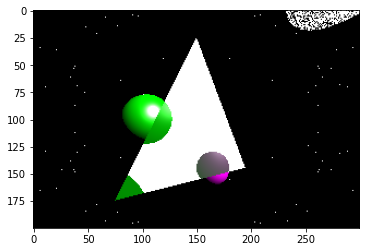

In [10]:
plt.imshow(image)

In [ ]:
plt.imsave('image.png', image)